### 관련 라이브러리 로드

In [ ]:
# 한국어 폰트를 설치합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (21.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and direc

In [ ]:
import pandas as pd
import numpy as np
import copy
import random

import matplotlib.pyplot as plt
import seaborn as sns
# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
sns.set_style('whitegrid')
plt.rc('font', family='NanumBarunGothic')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

## 1. 이상치 탐지 소개
이상치 탐지 태스크는 정상과 이상치 데이터가 존재하는 상황에서 이상치 데이터를 분류해야 하는 태스크입니다. \
이는 기존의 일반적인 분류 태스크와 두가지 관점에서 다른 점이 존재합니다.

1. 탐지하고자 하는 클래스가 특정됨 : 이상치 태스크는 정상 데이터를 잘 포착하기보다는 이상치 데이터를 잘 포착해야 합니다.
2. 극심한 데이터 불균형 : 일반적인 이상치 탐지 태스크는 정상 데이터는 매우 쉽게 구할 수 있지만 이상치 데이터는 매우 드문 경우를 포함합니다. 극단적인 경우 정상 데이터만으로 모델 학습이 가능하다고 간주하기도 합니다.

특히 2번과 같은 특성으로 인해 많은 이상치 탐지 방법론은 정상 데이터만으로 학습을 진행하게 됩니다. \
본 실습에서도 정상 데이터만으로 학습할 수 있는 모델 두가지를 이용하여 진행하도록 하겠습니다. \
해당 모델들에 대한 설명은 향후 교육을 통해 자세히 다뤄질 예정으로 이번 강의에선 모델 별 성능 차이를 지표 별로 살펴보는데 중점을 두도록 하겠습니다. \

금일 살펴볼 Integrated Error 및 Equal Error Rate(EER) 모두 Confusino Matrix를 이용하여 도출하는 지표입니다. \
Confusion Matrix를 이용하여 계산할 수 있는 지표 4가지와 공식은 아래와 같습니다.
1. **정확도 (Accuracy):**

   $\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$

2. **정밀도 (Precision):**

   $\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$

3. **재현율 (Recall):**

   $\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$

4. **F1 점수 (F1 Score):**

   $\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$
​


![](https://miro.medium.com/v2/resize:fit:1218/1*jMs1RmSwnYgR9CsBw-z1dw.png)

### 1-1. FRR-FAR 그래프
이때 AUROC 산출을 위해 사용하던 기존의 TPR-FPR 그래프가 아니라 FRR-FAR 그래프를 사용해야 합니다. \
해당 그래프는 강의에서 설명된 것처럼 아래와 같습니다.
- False Rejection Rate(FRR) : $\text{FP} \over (\text{FP} + \text{TN})$ \
FRR은 본래 정상 데이터이나 이상치 데이터로 잘못 탐지한 비율을 의미합니다.
- False Acceptance Rate(FAR) : $\text{FN} \over (\text{TP} + \text{FN})$ \
FAR은 본래 이상치 데이터이나 정상 데이터로 잘못 탐지한 비율을 의미합니다. \

예측확률과 실제값을 바탕으로 Integrated Error와 EER을 산출하는 순서는 아래와 같습니다.
1. AUROC 산출과 마찬가지로 예측 확률을 기준으로 데이터를 정렬한다.
2. Threshold를 변경하며 이상치/정상 데이터를 판별한다.
3. 2에서 고정된 Threshold 상황에서 정오 행렬을 도출한다.
4. 3에서 도출한 정오행렬로부터 FRR과 FAR을 산출한다.
5. 모든 Threshold에 대하여 3과 4의 과정을 반복한다.

위 과정을 반복하게 되면 강의에서 보셨던 것처럼 아래 그림이 도출되게 됩니다.

![](https://media.springernature.com/m685/springer-static/image/art%3A10.1007%2Fs00371-021-02119-0/MediaObjects/371_2021_2119_Fig7_HTML.png)

결과적으로 Integrated Error는 곡선 아래의 면적을, EER 값은 곡선과 y=x 선의 교점을 의미합니다. \
특히 EER은 TPR(FAR)과 FPR이 Threshold 변경에 따른 trade-off 관계에 있음을 이용하는 지표입니다. \
이를 이용하여 두 지표가 서로 동일해지는 지점의 FPR 혹은 FAR 값을 의미합니다. \
두 지표의 trade-off 관계에서 가장 낮은 지점이 낮을수록 해당 모델은 이상치 탐지를 잘 수행했다고 할 수 있습니다. \
즉 아래 그림에서 좋은 모델일 수록 EER이 산출되는 높이(y값)이 낮아질 것입니다.


![](https://miro.medium.com/v2/da:true/resize:fit:500/0*xvRUYCiotNxpn5-n.gif)

실제로는 FRR과 FAR 모두 아래 관계식을 가지게 됩니다.
- FRR = FPR
- FAR = 1-TPR

그러므로 우리는 Integrated Error와 EER을 구하기 위해 새로운 함수를 작성하는 것이 아니라 지난 시간에 작성한 AUROC 계산 함수를 수정하여 사용이 가능합니다.

### 1-2. Integrated Error 및 EER 구현

다만, 각 요소의 구동 방식을 이해하기 위해 하나씩 진행해보도록 하겠습니다.

#### 1-2-1. 예시 데이터 및 정오행렬
다음과 같은 모델의 예측값과 실제 값이 있다고 하겠습니다.  
이때, 저희가 집중적으로 관찰하고 싶은 예측 범주(공정 상 불량 제품 여부)를 0로 설정하고, 이외 범주(정상 제품)을 1으로 설정하겠습니다.

In [ ]:
prediction          = [1, 1, 1, 1, 1, 0, 0, 0, 0, 1]
actual              = [1, 0, 1, 1, 1, 0, 1, 0, 0, 0]

confusion_matrix = pd.crosstab(prediction, actual, rownames=['Predicted'], colnames=['Actual'])
confusion_matrix

Actual,0,1
Predicted,,
0,3,1
1,2,4


#### 1-5. AUROC 계산
AUROC는 모델의 예측 확률을 기반으로 계산됩니다. \
그러므로 이전까지의 계산과 다르게 모델이 각 데이터에 대해 1일 확률을 예측한 값을 기반으로 아래와 같이 계산될 수 있습니다. \
실제 계산 시에는 sklearn 패키지 내의 함수를 이용합니다. 하지만 동작 원리를 파악하기 위해서 아래 순으로 확인해봅시다.
1) fpr, tpr 계산 공식
2) 사다리꼴 넓이 계산 공식
3) AUROC 계산 함수

### 1-2-2. FPR, TPR 계산 함수
이전 시간에 다룬 FPR, TPR 계산 함수를 이용하도록 하겠습니다.

FPR은 False Positive Rate으로서 실제로 Negative(1)인 객체들에 대해 모델이 Positive(0)로 예측한 비율을 의미합니다. 공식으로 표현하면 아래와 같습니다.

$$ FPR = {n_{01} \over (n_{01} + n_{00})} $$

TPR은 True Positive Rate으로서 실제로 Positive인 객체들에 대해 모델이 Positive로 옳바르게 예측한 비율을 의미합니다. 공식으로 표현하면 아래와 같습니다.

$$ TPR = {n_{11} \over (n_{11} + n_{10})} $$




In [ ]:
## 위 두 공식을 함수로 구현하면 아래와 같습니다.
def get_TPR(confusion_matrix) :
    # TPR : True Positive Rate
    # TPR : True Positive / (True Positive + False Negative)
    return confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])

def get_FPR(confusion_matrix) :
    # FPR : False Positive Rate
    # FPR : False Positive / (False Positive + True Negative)
    return confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])


### 1-5-2. Threshold 별 TPR, FPR 계산

ROC는 모델이 예측한 확률에 대해 Threhold를 변경하며, 실제 예측값을 결정하면서 TPR과 FPR의 비율 변화를 모두 기록한 것입니다. 이는 1) Threshold를 변경하며 TPR과 FPR 계산 2) TPR과 FPR을 이용하여 Curve의 아래 넓이 계산 두 함수로 구현될 수 있습니다.

In [ ]:
def get_confusion_matrix(prediction, actual) :
    return pd.crosstab(prediction, actual, rownames=['Predicted'], colnames=['Actual'])

In [ ]:
def get_sadari(x_start, x_end, y_small, y_large) :
    """
    AUROC는 사다리꼴 너비의 합으로 계산됩니다.
    사다리꼴 너비를 구하는 함수입니다.
    """
    return (y_small + y_large) * (x_end - x_start) / 2

def get_AUROC(prediction, actual) :
    """
    AUROC : Area Under the Receiver Operating Characteristic Curve
    ROC 곡선의 아래 면적을 구하는 함수입니다.
    """
    # 1. prediction은 확률이므로, prediction을 기준으로 정렬합니다.

    prediction_sorted, actual_sorted = zip(*sorted(zip(prediction, actual), reverse=True))

    # 2. prediction을 기준으로 정렬된 actual을 기준으로 TPR, FPR을 구합니다.
    TPR_list = []
    FPR_list = []
    for i in range(len(prediction_sorted)) :
        if i != len(prediction_sorted) - 1 :
            if prediction_sorted[i] == prediction_sorted[i+1] :
                continue
        prediction_ = [0]*len(prediction_sorted)
        prediction_[:i+1] = [1]*(i+1)
        confusion_matrix = get_confusion_matrix(prediction_, actual_sorted)
        if confusion_matrix.shape != (2,2) :
            confusion_matrix = pd.DataFrame([[0,0],[0,0]])
        TPR = get_TPR(confusion_matrix)
        FPR = get_FPR(confusion_matrix)
        TPR_list.append(TPR)
        FPR_list.append(FPR)

    # 3. TPR, FPR을 기준으로 사다리꼴의 너비를 구합니다.
    AUROC = 0
    for i in range(len(TPR_list) - 2) :
        AUROC += get_sadari(FPR_list[i], FPR_list[i+1], TPR_list[i], TPR_list[i+1])
    return AUROC, TPR_list, FPR_list

#### 1-5-3. Integrated Error 계산 함수
Integrated Error는 AUROC의 반대값이므로 1-AUROC를 통해 산출할 수 있습니다.

In [ ]:
def get_integrated_error(auroc) :
    return 1-auroc

#### 1-5-4. EER 계산 함수

EER은 ROC 커브와 y=1-x 직선의 교점을 이루는 threhold를 통해 계산됩니다. 이를 산출하는 함수는 아래와 같이 구현할 수 있습니다.

In [ ]:
def get_eer(TPR_list, FPR_list) :
    """
    EER : Equal Error Rate
    TPR과 FPR이 같아지는 지점을 찾습니다.
    이는 TPR과 FPR의 부호가 반대인 지점을 찾는 것과 같습니다.
    """
    before_signal = TPR_list[0] - (1-FPR_list[0])
    for i in range(len(TPR_list)) :
        cur_signal = TPR_list[i] - (1-FPR_list[i])
        if before_signal * cur_signal <= 0 :
            FAR_cur = 1-TPR_list[i]
            FAR_before = 1-TPR_list[i-1]
            return ((FAR_cur + FAR_before) / 2 + (FPR_list[i] + FPR_list[i-1]) / 2) / 2

예측 확률과 실제값을 입력으로 integrated error와 eer을 산출하는 함수는 아래와 같이 정리 할 수 있습니다.

In [ ]:
def anomaly_detction_score(prediction, prob, actual) :
    """
    이상 탐지 성능을 평가하는 함수입니다.
    Integrated Error, EER, Accuracy를 출력합니다.
    """
    AUROC, TPR_list, FPR_list = get_AUROC(prob, actual)
    EER = get_eer(TPR_list, FPR_list)
    Integrated_Error = get_integrated_error(AUROC)
    accuracy = np.mean([1 if p == a else 0 for p, a in zip(prediction, actual)]) # 예측값과 실제값이 같은 비율을 계산합니다.
    confusion_matrix = get_confusion_matrix(prediction, actual)
    return AUROC, TPR_list, FPR_list, EER, Integrated_Error, accuracy, confusion_matrix

<ipython-input-3-678b82025585>:5: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
<ipython-input-3-678b82025585>:10: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])
<ipython-input-9-411b2c545b54>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([1,0], [0,1], 'k--', color='red', label="y=1-x")


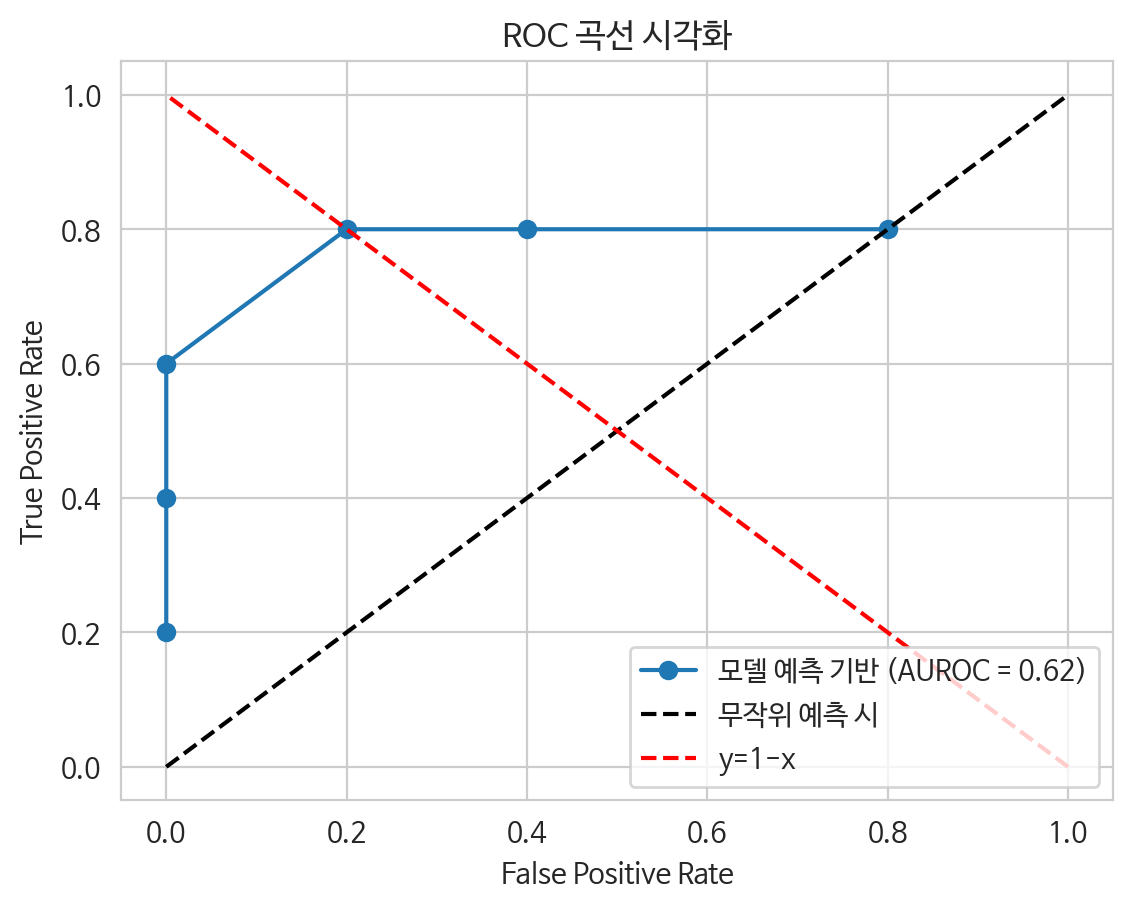

In [ ]:
actual = [1, 0, 1, 1, 1, 0, 1, 0, 0, 0]
prob   = [0.9, 0.6, 0.6, 0.8, 0.7, 0.2, 0.1, 0.3, 0.2, 0.1]
prediction = [1 if p > 0.5 else 0 for p in prob]
auroc, tpr, fpr, eer, integrated_error, accuracy, confusion_matrix = anomaly_detction_score(prediction, prob, actual)
plt.plot(fpr, tpr, 'o-', label="모델 예측 기반 (AUROC = %0.2f)" % auroc)
plt.plot([0, 1], [0, 1], 'k--', label="무작위 예측 시")
plt.plot([1,0], [0,1], 'k--', color='red', label="y=1-x")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC 곡선 시각화')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(f"Integrated Error : {integrated_error:.2f}")
print(f"EER : {eer:.2f}")
print(f"Accuracy : {accuracy:.2f}")

Integrated Error : 0.38
EER : 0.20
Accuracy : 0.80


위 지표를 해석해보면 아래와 같습니다.
- Accuracy : 전체 데이터 10건 중 80%인 8건에 대해서는 정답을 맞추었다.
- Integrated Error : Threhold를 조정하여 정상 데이터와 이상치 데이터의 오분류율을 조정하였을 때, 0.38의 수치가 산출되었다.
- EER : 정상 데이터와 이상치 데이터 균형있게 분류하는 Threshold에서의 오분류는 0.2로 일어난다. \
위 해석을 살펴보면 사실상 Integrated Error는 직관적 해석은 어렵지만, Threshold 선정과 무관한 평가가 가능하다는 장점이 있음을 알 수 있습니다. \
또한, EER의 경우 Threshold를 따로 선정할 필요가 없으며 해석이 가능하다는 장점이 존재합니다. \
기존 분류 태스크에서 널리 사용되는 Accuracy 등의 지표는 해석이 편리하다는 장점이 있습니다. \
다만, 이상치 분류 태스크 특성을 고려한다면 두 지표를 사용하는 것이 매우 중요하다고 할 수 있습니다. \
이와 관련하여 향후 실험을 통해 조금 더 살펴보도록 하겠습니다.

## 2. 데이터 소개

실습 데이터셋은 sklearn의 make_classification 함수를 통해 임의로 생성해보도록 하겠습니다.

이때, 매우 적은 비중을 차지하는 클래스를 이상치 클래스로 간주하고, 학습 데이터에서 제외하는 것이 기존 분류 태스크와 다른 점입니다.

실습에서 사용될 데이터는 아래와 같은 조건을 가지고 있게 됩니다.
- 데이터 수 : 1,000건
- 변수 수 : 20건
- 클래스 수 : 2개
- 클래스 비율 : 1 대 99

생성된 데이터의 클래스 비율은 의도적으로 1대 99로 설정해보겠습니다. \
이상치 데이터의 경우 실제로는 더욱 극단적인 비율을 가지는 경우도 다수 존재하므로, 이와 같은 극단적 설정을 통해 기존 분류 태스크와 다른 점을 포착할 수 있습니다.

In [ ]:
from sklearn.datasets import make_classification

In [ ]:
dataset = make_classification(
    n_samples=5000,
    n_features=10,
    n_classes=2,
    random_state=42,
    class_sep=0.1,
    weights=[0.01, 0.99]
    )

In [ ]:
# X : 독립변수, y : 종속변수
# X를 입력으로 하여 이상치(y)를 분류하는 태스크라 할 수 있습니다.
X, y = dataset

In [ ]:
print(X[:2])

[[ 1.86419953 -1.4711592  -0.67130759 -0.37680566  1.31347316  0.0891982
  -1.12529556 -0.50376815 -0.69646109 -0.07686541]
 [ 0.33548674  0.71593421 -2.02015145  0.30156821  1.23795353 -0.82191278
   0.97091233 -0.03174127  0.38546963  0.13372972]]


In [ ]:
print(y[:2]) # 대부분의 데이터가 1로 레이블링 되어 있습니다.

[0 1]


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


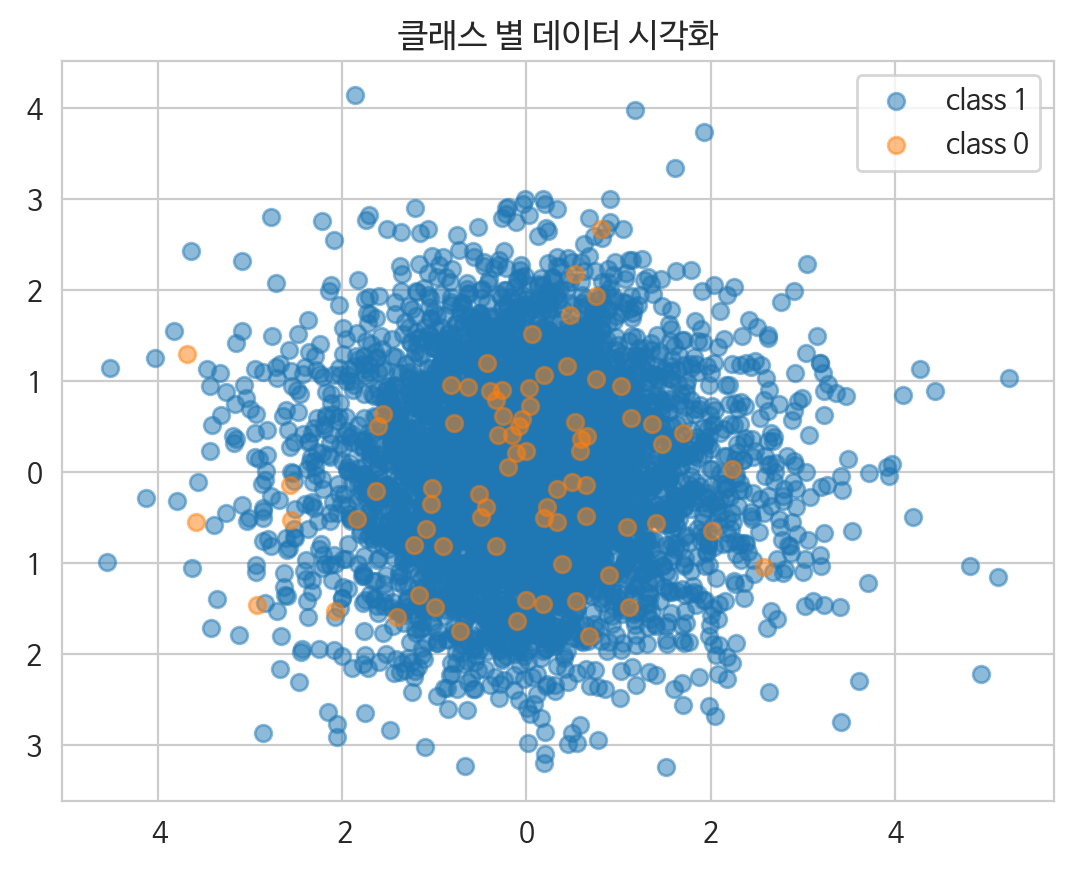

In [ ]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
X_for_pca = X
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_for_pca)

# scatter plot을 그립니다.
# c : 색상, s : 크기
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label="class 1", alpha=0.5)
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label="class 0", alpha=0.5)
plt.title('클래스 별 데이터 시각화')
plt.legend()
plt.show()

### 3. 데이터 분할
주어진 데이터를 분할하여 학습/평가/테스트 용 데이터를 생성하도록 하겠습니다. \
앞서 설명했다시피 학습/평가/테스트 데이터는 아래와 같이 구성되어야 합니다.

- 학습 데이터 : 정상데이터(클래스 1)로만 구성
- 평가/테스트 데이터 : 정상 데이터 및 이상치 데이터로 구성 (불균형 극심)

In [ ]:
# 클래스 별 데이터를 분리합니다.
class_0_idx = np.where(y == 0)[0]
class_1_idx = np.where(y == 1)[0]

X_class_0 = X[class_0_idx]
X_class_1 = X[class_1_idx]
y_class_0 = y[class_0_idx]
y_class_1 = y[class_1_idx]

# 클래스 0 데이터를 평가/테스트 데이터로 나눕니다.
X_class_0_val, X_class_0_test, y_class_0_val, y_class_0_test = train_test_split(X_class_0, y_class_0, test_size=0.5, random_state=42)

# 클래스 1 데이터를 학습/평가/테스트 데이터로 나눕니다.
X_train, X_class_1_val, y_train, y_class_1_val = train_test_split(X_class_1, y_class_1, test_size=0.3, random_state=42)
X_class_1_val, X_class_1_test, y_class_1_val, y_class_1_test = train_test_split(X_class_1_val, y_class_1_val, test_size=0.5, random_state=42)

# 평가/테스트 데이터를 합칩니다.
X_val = np.concatenate([X_class_0_val, X_class_1_val])
y_val = np.concatenate([y_class_0_val, y_class_1_val])
X_test = np.concatenate([X_class_0_test, X_class_1_test])
y_test = np.concatenate([y_class_0_test, y_class_1_test])

각 데이터 내 이상치 클래스(0)의 비율을 확인해보면 1) 학습 데이터 내 이상치 데이터가 없고, 2) 평가/테스트 데이터 내에도 극소량만 존재하는 것을 확인할 수 있습니다.

In [ ]:
num_class_0_train = sum((i for i in y_train if i == 0))
print("학습 데이터 내 클래스 0 비율 : ", (num_class_0_train) / (num_class_0_train + len(y_train)))
print("평가 데이터 내 클래스 0 비율 : ", len(y_class_0_val) / (len(y_class_0_val) + len(y_class_1_val)))
print("테스트 데이터 내 클래스 0 비율 : ", len(y_class_0_test) / (len(y_class_0_test) + len(y_class_1_test)))

학습 데이터 내 클래스 0 비율 :  0.0
평가 데이터 내 클래스 0 비율 :  0.04896907216494845
테스트 데이터 내 클래스 0 비율 :  0.05012853470437018



### 4. 학습 및 평가

실험을 용이하게 진행하기 위하여 모델의 학습 및 평가를 실행할 함수를 작성해보도록 하겠습니다. \
해당 함수는 다음과 같은 과정을 수행합니다. \
특히 기존 분류 모델과 달리 해당 실습의 이상치 탐지 모델은 예측레이블(이상치 여부)를 사용하지 않고 입력 데이터(X)만 사용하는 것이 특징입니다.

1. 모델 지정
2. 학습 데이터에 대해 모델 학습 진행
3. 학습된 모델로부터 평가 데이터 예측값 및 확률 반환
4. 평가 데이터의 실제값과 예측/확률을 바탕으로 지표 계산

In [ ]:
def train_val_model(model, X_train, X_val, y_val) :
    # 주어진 학습/평가 데이터를 이용하여 모델을 훈련 및 평가하는 함수입니다.
    model_trained = copy.deepcopy(model)
    model_trained.fit(X_train) # 학습 데이터를 이용하여 모델을 훈련합니다. 이때 y값은 사용하지 않습니다.
    # return probability
    pred_proba = model_trained.score_samples(X_val)
    prediction = model_trained.predict(X_val) # 훈련된 모델을 검증 데이터에 적용하여 예측값을 구합니다.
    auroc, tpr, fpr, eer, integrated_error, accuracy, confusion_matrix = anomaly_detction_score(prediction, pred_proba, y_val)
    return [auroc, tpr, fpr, eer, integrated_error, accuracy, confusion_matrix], model_trained

### 5. 후보 모델 평가
위에서 작성된 함수들을 바탕으로 실제 평가를 수행해보겠습니다.\
만약 주어진 태스크에 대해 모델을 탐색한다고 가정할 때, 일반적으로 어떤 모델 구조(knn, Random Forest, SGBoost, SVM, MLP 등)를 사용하고, 하이퍼 파라미터를 사용하는지에 따라 성능이 변하게 됩니다. \
이번 실습에서는 Local Outlier Factor와 Isolation Forest 두 모델에 대하여 진행해보겠습니다.  
이때, 평가 결과를 바탕으로 최종 모델을 선정하고, 테스트 데이터에 대한 성능을 산출해야 하므로, 각 모델을 저장하는 dictionary 역시 함께 활용하겠습니다.

In [ ]:
result_df = pd.DataFrame(columns=['model', 'auroc','eer', 'integrated_error', 'accuracy'])
confusion_matrix_dict = {}
model_dict = {}
from sklearn.neural_network import MLPClassifier
for model_name in ['lof', 'iforest'] :
    print(f"Model : {model_name}")
    if model_name == 'lof' :
        model = LocalOutlierFactor(novelty=True)
    elif model_name == 'iforest' :
        model = IsolationForest()

    [auroc, tpr, fpr, eer, integrated_error, accuracy, confusion_matrix], model = train_val_model(model, X_train, X_val, y_val)
    result_df = result_df.append({
        'model' : model_name,
        'auroc' : round(auroc, 4),
        'eer' : round(eer, 4),
        'integrated_error' : round(integrated_error, 4),
        'accuracy' : round(accuracy, 4)
        }, ignore_index=True)
    confusion_matrix_dict[model_name] = confusion_matrix
    model_dict[model_name] = model

Model : lof


<ipython-input-3-678b82025585>:5: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
<ipython-input-3-678b82025585>:10: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])
<ipython-input-20-575617f20781>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


Model : iforest


<ipython-input-3-678b82025585>:5: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
<ipython-input-3-678b82025585>:10: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])
<ipython-input-20-575617f20781>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({


In [ ]:
result_df

,model,auroc,eer,integrated_error,accuracy
0,lof,0.5627,0.4359,0.4373,0.9420
1,iforest,0.5613,0.4640,0.4387,0.8325


## 6. 평가 결과 해석
### 6-1. Accuracy 기준 평가 해석
Accuracy를 기준으로 해석한다면 LoF의 성능이 Isolation Forest보다 높다고 해석할 수 있습니다. \
하지만 이상치 태스크에서 성능은 1) 극단적으로 불균형한 데이터셋에서 2) 이상치 탐지 능력이 중요합니다. \
이를 확인하기 위해 정오 행렬을 확인해보도록 하겠습니다.

In [ ]:
print("Model : Local Outlier Factor")
print("-"*30)
print(confusion_matrix_dict['lof'])
print("="*30)
print("Model : Isolation Forest")
print("-"*30)
print(confusion_matrix_dict['iforest'])

Model : Local Outlier Factor
------------------------------
Actual      0    1
Predicted         
-1          0    1
 1         39  738
Model : Isolation Forest
------------------------------
Actual      0    1
Predicted         
-1          9   88
 1         30  651


실제 정오 행렬 상에서는 LoF는 이상치를 전혀 탐지하지 못하고 모두 정상 데이터로 간주한 것을 볼 수 있습니다. \
하지만 정상 데이터가 극단적으로 많은 상황으로 이러한 경우에도 AUROC나 Accuracy는 높은 값을 가질 수 있습니다. \

만약 Accuracy 및 AUROC를 기준으로 LoF가 적합한 모델로 판단하여 실제 테스트를 한다면 아래와 같은 성능이 도출 될 것입니다.

## 7. 테스트 데이터

In [ ]:
result_df = pd.DataFrame(columns=['model', 'auroc','eer', 'integrated_error', 'accuracy'])
confusion_matrix_dict = {}
for model_name, model in model_dict.items() :
    result_dict = {}
    pred = model.predict(X_test)
    pred_proba = model.score_samples(X_test)
    auroc, tpr, fpr, eer, integrated_error, accuracy, confusion_matrix = anomaly_detction_score(pred, pred_proba, y_test)
    result_df = result_df.append({
        'model' : model_name,
        'auroc' : round(auroc, 4),
        'eer' : round(eer, 4),
        'integrated_error' : round(integrated_error, 4),
        'accuracy' : round(accuracy, 4)
        }, ignore_index=True)

    confusion_matrix_dict[model_name] = confusion_matrix



<ipython-input-3-678b82025585>:5: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
<ipython-input-3-678b82025585>:10: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])
<ipython-input-25-12f2e37456b8>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({
<ipython-input-3-678b82025585>:5: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[1][1] / (confusion_matrix[1][0] + confusion_matrix[1][1])
<ipython-input-3-678b82025585>:10: RuntimeWarning: invalid value encountered in long_scalars
  return confusion_matrix[0][1] / (confusion_matrix[0][0] + confusion_matrix[0][1])
<ipython-input-25-12f2e37456b8>:8: FutureWarning: The frame.append method is deprecated and w

In [ ]:
result_df

,model,auroc,eer,integrated_error,accuracy
0,lof,0.5919,0.4186,0.4081,0.9486
1,iforest,0.5535,0.4720,0.4465,0.8368


In [ ]:
for model_name in ['lof', 'iforest'] :
    print(f"Model : {model_name}")
    print("-"*30)
    print(confusion_matrix_dict[model_name])
    print("="*30)

Model : lof
------------------------------
Actual      0    1
Predicted         
-1          0    1
 1         39  738
Model : iforest
------------------------------
Actual      0    1
Predicted         
-1          9   88
 1         30  651


최종 결과를 살펴보면 Accuracy에서 높은 결과를 보여주었던 LoF가 테스트 데이터에 대해서도 높은 Accuracy를 기록하고 있는 것을 알 수 있습니다. \
그리고 이러한 원인 역시 여전히 모든 데이터를 정상 데이터로 예측하는 데 기인하고 있음을 정오행렬을 통해 확인할 수 있습니다. \
그에 비해 Accuracy에서는 낮은 성능을 보였지만, EER과 Integrated Error에서 높은 성능을 보였던, Isolation Forest는 테스트 데이터에 대해서도 일부 이상치를 탐지한 것을 볼 수 있습니다. \
정오 행렬을 확인하면 일부 정상 데이터 역시 이상치 데이터로 탐지하였으나, 공정 등에서 이상치 데이터를 탐지하는 것이 정상 데이터를 이상치로 오분류(False Positive) 하는 것보다 중요하므로 Isolation Forest가 적용할 수 있는 후보 모델이 될 수 있음을 알 수 있습니다. \

본 실습에서 사용된 모델이 매우 단순하고, 임의로 생성된 데이터로 두 모델 모두 성능이 낮은 상황입니다. 향후 교육을 통해 접하실 다양한 이상치 탐지 방법론들은 해당 방법론들에 비해 높은 성능을 보이고 있습니다!